In [1]:
%load_ext autoreload
%autoreload 2

# Look at the impact of the association

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
proj = ccrs.PlateCarree()

#External functions 
import fct.fct_link_storm_claim as fct_link_storm_claim
import fct.preprocess_sinclim as preprocess_sinclim
import fct.fct_plot_claims as fct_plot_claims
from fct.paths import *

path_save_fig = PATH_FIGURE+"association_impact/"

In [3]:
period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

df_info_storm_FR                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm_FR['storm_landing_date'] = pd.to_datetime(df_info_storm_FR['storm_landing_date'])
df_storm_FR                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm_FR.storm_id.nunique()} number of storms - FR")

# df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
# df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
# df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

########## IMPACT DATA 
window              = 'd-3_d+3'
min_claim           = 50
method              = 'wgust'
r_sinclim           = 1300
r_varying           = False
sinclim_version     = "v2.2"
sinclim_date        = "v200126"
sinclim_peril       = "storm" #"storm" # "storm_extended"

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, sinclim_version, sinclim_peril, sinclim_date, window, min_claim, method, "1997-2024", r_sinclim, False)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]
print(f"{df_info_storm_impact.storm_id.nunique()} storms with impact")

#Add storm_landing date and SSI
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')

#Load clusters 
windi      = 96
r_cluster  = 700

r_part_sinclim = f"r-varying" if r_varying else f"r{r_sinclim}"
r_part_clust = f"_r{r_cluster}" if r_cluster is not None else ""
fname_cluster = f"tracks_FR_ALL_24h_impact_{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_{r_part_sinclim}_{sinclim_date}_clust-mult-2storms-{windi}h{r_part_clust}_{period}"
df_storm_cluster_test                            = pd.read_csv(PATH_TRACKS+fname_cluster+".csv", encoding='utf-8')
df_info_mult_cluster_test                       = pd.read_csv(PATH_TRACKS+fname_cluster+"_info.csv", encoding='utf-8')
df_info_mult_cluster_test['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster_test['storm_landing_date'])

9881 number of storms
4439 number of storms - FR
322 storms with impact


## On the date of declaration

In [4]:
# Compute days difference (if not already done)
sinclim['days_diff_abs'] = np.abs((sinclim['dat_sin'] - sinclim['storm_landing_date']).dt.days)
sinclim['hours_diff_abs'] = np.abs((sinclim['dat_sin'] - sinclim['storm_landing_date']).dt.total_seconds() / 3600)

In [5]:
len(sinclim.loc[sinclim.hours_diff_abs <= 24])/len(sinclim)

0.7761470581842683

In [6]:
0.5+0.37+0.07+0.02

0.96

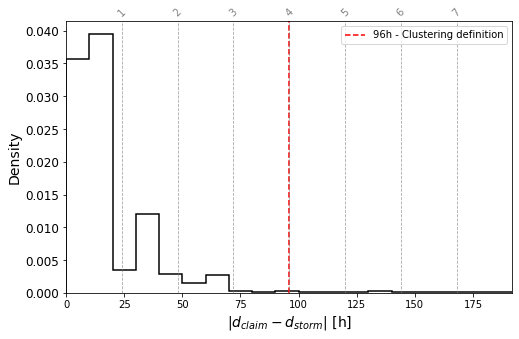

In [31]:
# Define bins for each day from -10 to 10
nb_max_days = 8
fontsize=14
# bins = np.arange(0, nb_max_days+1, 1)
bins = np.arange(0, 24*(nb_max_days+1), 10)

fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(
    sinclim['hours_diff_abs'],
    bins=bins,
    density=True,
    histtype='step',
    linewidth=1.5, 
    color="black"
)
#plt.xlabel('Days between claim and storm landing')
plt.xlabel(r"$|d_{claim} - d_{storm}|$ [h]", fontsize=fontsize)
plt.ylabel('Density', fontsize=fontsize)
# plt.title('Distribution of Claim Date vs Storm Landing', fontsize=fontsize+2)
plt.axvline(96, color='red', linestyle='--', label='96h - Clustering definition')
plt.xlim(0, 24*nb_max_days)
# plt.xticks(range(0, nb_max_days+1), fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.legend()

# --- Add thin vertical lines every 24h ---
# max_duration = max(s["duration_hours"].max() for s in storm_stats) # get the max value

for day in range(1, nb_max_days): # +2 to ensure the last line is included
    ax.axvline(x=24*day, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# --- Label the day numbers on top
for day in range(1, nb_max_days):
    ax.text(24*day, ax.get_ylim()[1]*1.01, f"{day}", rotation=45, ha='center', va='bottom', fontsize=10, color='gray')

fig.savefig(path_save_fig+f"Absolute_difference_dates-{method}-{window}-min{min_claim}_r{r_sinclim}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Absolute_difference_dates-{method}-{window}-min{min_claim}_r{r_sinclim}.pdf", 
            format="pdf", transparent=True, bbox_inches='tight', dpi=300)

## On the associated wgust

In [4]:
sinclim['dat_sin'] = pd.to_datetime(sinclim['dat_sin'])
sinclim['dat_sin_year'] = sinclim['dat_sin'].dt.year
sinclim['dat_sin_month'] = sinclim['dat_sin'].dt.month
sinclim['dat_sin_day'] = sinclim['dat_sin'].dt.day

In [5]:
import pandas as pd
import numpy as np
import xarray as xr
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from pathlib import Path
import dask

PATH_WGUST_DAILYMAX = "/home/estimr3/bdd/ERA5/North_Atlantic_22p5N_70N_80W_50E/daily/wgust"

# Enable splitting of large slices into smaller chunks (recommended)
dask.config.set(array_slicing_split_large_chunks=True)

In [6]:
def open_wgust_dailymax(path_wgust, sinclim_pd):
    """
    Open daily maximum wind gust ERA5 files only for years present in sinclim_pd
    """
    years = pd.to_datetime(sinclim_pd["dat_sin"]).dt.year.unique()
    years = np.sort(years)

    files = [
        Path(path_wgust) / f"windgust_10m_dailymax_{y}.nc"
        for y in years
    ]

    ds = xr.open_mfdataset(
        files,
        combine="by_coords",
        parallel=True,
        chunks={"time": 30, "lat": 100, "lon": 200}
    )

    return ds

In [7]:
def add_wgust_dat_sin(
    sinclim_pd,
    path_wgust="/home/estimr3/bdd/ERA5/North_Atlantic_22p5N_70N_80W_50E/daily/wgust",
    show_progress=True,
):
    """
    Adds column 'wgust_dat_sin' using ERA5 daily maximum wind gust
    """

    sinclim_pd = sinclim_pd.copy()
    sinclim_pd["dat_sin"] = pd.to_datetime(sinclim_pd["dat_sin"]).dt.normalize()

    # Open ERA5 dailymax dataset
    ds = open_wgust_dailymax(path_wgust, sinclim_pd)

    wgust_values = []

    iterator = sinclim_pd.iterrows()
    if show_progress:
        iterator = tqdm(iterator, total=len(sinclim_pd), desc="Extracting daily wgust")

    for _, row in iterator:
        try:
            val = (
                ds["fg10"]
                .sel(
                    time=row["dat_sin"],
                    latitude=row["num_lat"],
                    longitude=row["num_lon"],
                    method="nearest",
                )
                .values
            )

            wgust_values.append(float(val))

        except Exception:
            wgust_values.append(np.nan)

    sinclim_pd["wgust_dat_sin"] = wgust_values
    return sinclim_pd

In [ ]:
sinclim = add_wgust_dat_sin(
    sinclim_pd=sinclim,
    path_wgust = PATH_WGUST_DAILYMAX, 
    show_progress=True
)

Extracting daily wgust:  86%|████████▌ | 157398/184036 [1:49:42<20:19, 21.85it/s]  

In [33]:
sinclim.head()

,cod_sin,cod_pol,dat_sin,dat_dec,dat_clo,cod_cie,cod_ent,cod_res,lib_res,lib_eta,...,coef_inflation,num_chg_brut_cst,min_slp,storm_landing_date,track_id_origin,days_diff,dat_sin_year,dat_sin_month,dat_sin_day,wgust_dat_sin
0,0036501583,00014105059,1998-01-20,1998-01-21,2003-01-17,1,GIARD,GA,agent,clos,...,78.2,3221.80090,97921.40,1998-01-18 12:00:00,1526,1,1998,1,20,19.275166
1,0037000227,00054532764,1998-01-02,1998-01-21,2003-01-10,1,GIARD,GA,agent,clos,...,78.2,654.04134,96418.86,1998-01-04 12:00:00,1005,-3,1998,1,2,30.454870
2,0037000496,00020086266,1998-01-04,1998-01-08,2003-01-25,1,GIARD,GA,agent,clos,...,78.2,244.75818,97283.15,1998-01-02 06:00:00,962,1,1998,1,4,25.922901
3,0037002709,00020085494,1998-01-03,1998-10-27,2001-12-24,1,GIARD,GA,agent,clos,...,78.2,228.04684,97283.15,1998-01-02 06:00:00,962,0,1998,1,3,25.550064
4,0037080744,00020103996,1998-02-13,1999-04-09,2002-10-04,1,GIARD,GA,agent,clos,...,78.2,438.11550,97921.40,1998-01-18 12:00:00,1526,25,1998,2,13,4.872040


In [26]:
sinclim[["dat_sin", "num_lon", "num_lat"]].head()

,dat_sin,num_lon,num_lat
0,1998-01-20,2.376356,51.035823
1,1998-01-02,-4.176566,48.657865
2,1998-01-04,2.417161,47.101383
3,1998-01-03,-0.759429,48.060964
4,1998-02-13,3.063060,49.890489


In [41]:
sinclim['wgust_diff']

0          2.148342
1          1.983644
2          0.168320
3          0.917614
4         14.774155
            ...    
184031    16.399143
184032     0.000000
184033     0.248726
184034    -8.662586
184035     3.656776
Name: wgust_diff, Length: 184036, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


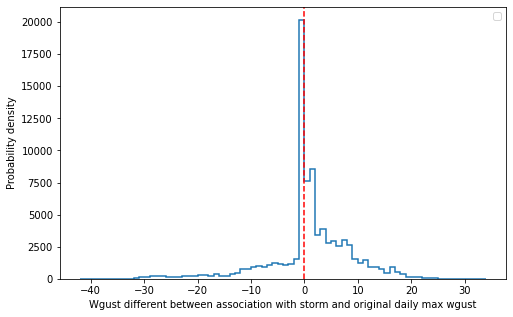

In [47]:
# Compute days difference (if not already done)
sinclim['wgust_diff'] = (sinclim['wgust_max'] - sinclim['wgust_dat_sin'])

sinclim_wind_diff = sinclim.loc[sinclim.wgust_diff != 0]

# Define bins for each day from -10 to 10
bins = np.arange(sinclim_wind_diff.wgust_diff.min(), sinclim_wind_diff.wgust_diff.max()+1, 1)  # center bins on integers

plt.figure(figsize=(8,5))
plt.hist(
    sinclim_wind_diff['wgust_diff'],
    bins=bins,
#     density=True,
    histtype='step',
    linewidth=1.5
)
plt.xlabel('Wgust different between association with storm and original daily max wgust')
plt.ylabel('Probability density')
# plt.title('Distribution of Claim Date vs Storm Landing')
plt.axvline(0, color='red', linestyle='--')#, label='Storm landing day')
# plt.xlim(-10, 10)
# plt.xticks(range(-10, 11))
plt.legend()
plt.show()